In [1]:
# In this project we'll classify various generation 1 pokemons like Pikachu, Mewtow, Charmander, etc based on their
# images using a CNN.

In [2]:
# For this project dataset was taken from the following links:
# https://www.kaggle.com/thedagger/pokemon-generation-one

In [37]:
# Libraries Used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import gc
import requests
import random
from PIL import Image
from io import BytesIO
from collections import Counter

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [4]:
# Now we'll look at the data and see how many images are there for each type of pokemon. Following is the code for 
# the same

('Total number of categories are', 150)
('Total number of images in dataset is', 10842)


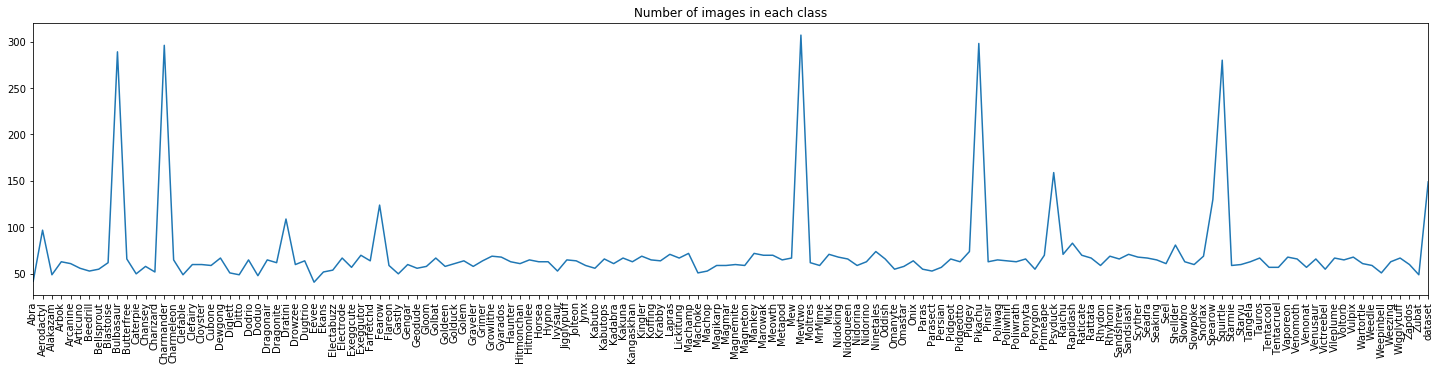

In [5]:
path = 'dataset_original'  # Specifies path of dataset. 
classes = os.listdir(path)  # Gives list of classes
print('Total number of categories are', len(classes))

# We'll see the number of images in each class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
print('Total number of images in dataset is', sum(list(counts.values())))

# Plot for number of images in each class
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x = 0)
plt.show()

In [6]:
# Clearly, the dataset is highly unbalance. About 9 classes have a lot of images but the other classes have very few
# images. Training a model on all classes would greatly decrease the final accuracy. So we'll use only 5 classes 
# which have sufficient data. 

# We'll also see the actual number of images in each category.

In [7]:
sorted_list = sorted(counts.items(), key = lambda item: item[1], reverse = True)
sorted_list

[('Mewtwo', 307),
 ('Pikachu', 298),
 ('Charmander', 296),
 ('Bulbasaur', 289),
 ('Squirtle', 280),
 ('Psyduck', 159),
 ('dataset', 149),
 ('Spearow', 130),
 ('Fearow', 124),
 ('Dratini', 109),
 ('Aerodactyl', 97),
 ('Rapidash', 83),
 ('Shellder', 81),
 ('Pidgey', 74),
 ('Ninetales', 74),
 ('Machamp', 72),
 ('Mankey', 72),
 ('Raichu', 71),
 ('Lapras', 71),
 ('Sandslash', 71),
 ('Muk', 71),
 ('Primeape', 70),
 ('Exeggutor', 70),
 ('Marowak', 70),
 ('Raticate', 70),
 ('Meowth', 70),
 ('Growlithe', 69),
 ('Snorlax', 69),
 ('Kingler', 69),
 ('Rhyhorn', 69),
 ('Vulpix', 68),
 ('Scyther', 68),
 ('Gyarados', 68),
 ('Vaporeon', 68),
 ('Nidoking', 68),
 ('Mew', 67),
 ('Tauros', 67),
 ('Wigglytuff', 67),
 ('Rattata', 67),
 ('Lickitung', 67),
 ('Vileplume', 67),
 ('Golbat', 67),
 ('Seadra', 67),
 ('Electrode', 67),
 ('Kakuna', 67),
 ('Dewgong', 67),
 ('Oddish', 66),
 ('Butterfree', 66),
 ('Nidoqueen', 66),
 ('Ponyta', 66),
 ('Kabutops', 66),
 ('Venusaur', 66),
 ('Sandshrew', 66),
 ('Venomoth', 66

In [8]:
# We'll only consider the top 5 classes with most number of images which are Mewtwo, Pikachu, Charmander, Bulbasaur,
# Squirtle. Following code shows the classes with most number of images.

# Gives names as well as number of photos in each class
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Gives only names of classes
imbalanced = [i[0] for i in imbalanced]   
print(imbalanced)

[('Mewtwo', 307), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [9]:
# Now we'll create a dataset for these categories and work on that dataset only. So that our original data doesn't 
# get lost, we make a copy of the entire dataset at first.

In [13]:
shutil.copytree('dataset_original', 'dataset_original_copy')

In [14]:
# Now we'll create a new dataset for the 5 classes which have maximum number of images

In [15]:
os.makedirs('dataset_new')

In [16]:
src = 'dataset_original_copy/'
dest = 'dataset_new'
folder = ['Bulbasaur', 'Charmander', 'Mewtwo', 'Pikachu', 'Squirtle']
for i in folder:
    shutil.move(src + i, dest)

In [18]:
# Now we'll use dataset_new to train our model and make final predictions on it. First of all we'll explore this 
# newly created dataet

('Total number of categories are', 5)
('Total number of images in dataset is', 1470)


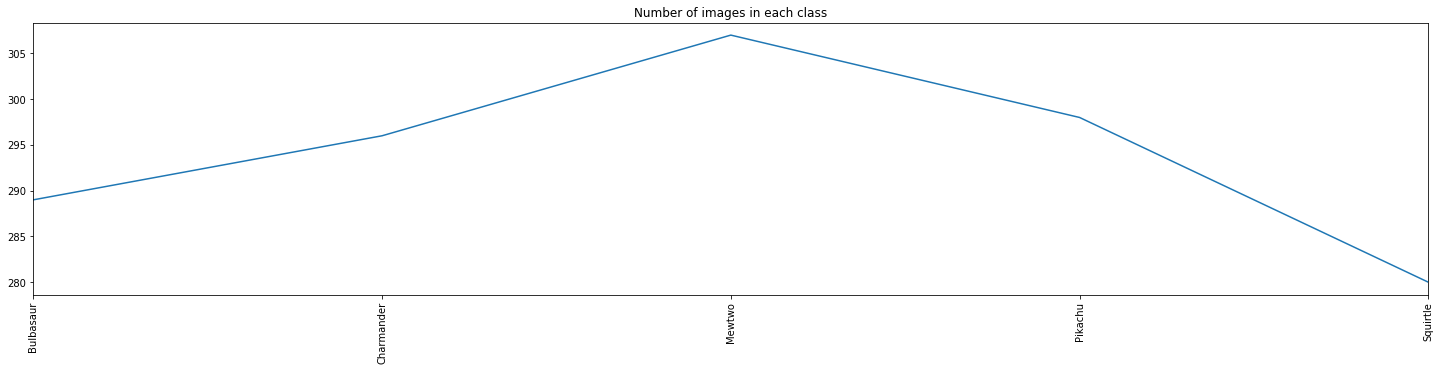

In [19]:
path = 'dataset_new'  # Specifies path of dataset. 
classes = os.listdir(path)  # Gives list of classes
print('Total number of categories are', len(classes))

# We'll see the number of images in each class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
print('Total number of images in dataset is', sum(list(counts.values())))

# Plot for number of images in each class
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x = 0)
plt.show()

In [20]:
# Now we'll take the required images from these 5 classes and make a list as shown in the code

X = []  # List for images
Y = []  # List for labels

# Loop through all classes
for c in classes:
    # We'll consider only those 5 classes defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c)

        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv2.imread(os.path.join(dir_path, i))
            try:
                resized = cv2.resize(image, (96, 96))  # Resize image to (96, 96)
                X.append(resized)
                Y.append(label)
            except:  # If we can't read a particular image we skip it
                print(os.path.join(dir_path, i), "[ERROR] can't read the file")
                continue

print("Done")

('dataset_new/Mewtwo/ed9eb0e7d3494c6992e06196f5b7cc05.svg', "[ERROR] can't read the file")
Done


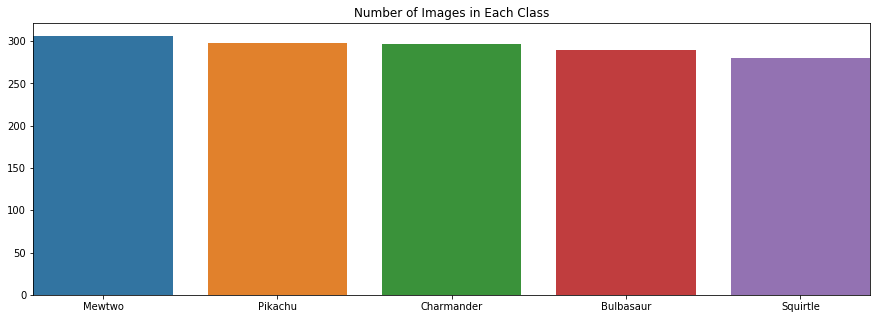

In [21]:
# For these 5 classes we'll see the number of images in each class graphically as shown in below code

# Counting number 
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of Images in Each Class')
plt.margins(x = 0)
plt.show()

In [22]:
# We have 5 classes with approx 300 images in each class

In [23]:
# Convert list with images to numpy array and reshape it
X = np.array(X).reshape(-1, 96, 96, 3)

# Scaling the data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

# Splitting data to training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, shuffle = True, random_state = 666)

In [25]:
# We'll now build our model as shown

In [26]:
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(256, 3, padding = 'same', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(imbalanced), activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        3

In [27]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [24]:
# Since we don't have much data, we'll be doing data augmentation using ImageDataGenerator library. Doing this will
# apply random transformations to our images. Data augmentation increases size of our dataset and thus helps 
# increasing accuracy

In [29]:
train_datagen = ImageDataGenerator(horizontal_flip = True, rotation_range = 45, width_shift_range = 0.15, height_shift_range = 0.15, zoom_range = 0.2, shear_range = 0.2)
test_datagen = ImageDataGenerator(horizontal_flip = True)
train_generator =  train_datagen.flow(X_train, y_train, batch_size = 32, shuffle = True)
val_generator = test_datagen.flow(X_test, y_test, batch_size = 32, shuffle = True)

In [30]:
history = model.fit_generator(train_generator, validation_data = val_generator, epochs = 100, steps_per_epoch = len(train_generator),validation_steps = len(val_generator), verbose = 1)

W0413 12:43:18.266694 140736039502720 deprecation.py:323] From <ipython-input-30-ab58b73351cf>:1: fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0413 12:43:18.484833 140736039502720 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0413 12:43:18.535164 140736039502720 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 35 steps, validate for 12 steps
Epoch 1/100
35/35 [==============================] - 90s 3s/step - loss: 1.4721 - accuracy: 0.5077 - val_loss: 1.3661 - val_accuracy: 0.4973
Epoch 2/100
35/35 [==============================] - 90s 3s/step - loss: 0.8822 - accuracy: 0.6994 - val_loss: 1.7174 - val_accuracy: 0.5326
Epoch 3/100
35/35 [==============================] - 109s 3s/step - loss: 0.8654 - accuracy: 0.7293 - val_loss: 0.8594 - val_accuracy: 0.7391
Epoch 4/100
35/35 [==============================] - 119s 3s/step - loss: 0.7469 - accuracy: 0.7566 - val_loss: 2.4367 - val_accuracy: 0.5489
Epoch 5/100
35/35 [==============================] - 122s 3s/step - loss: 0.6337 - accuracy: 0.7866 - val_loss: 0.6585 - val_accuracy: 0.7826
Epoch 6/100
35/35 [==============================] - 144s 4s/step - loss: 0.5773 - accuracy: 0.8029 - val_loss: 0.4187 - val_accuracy: 0.8723
Epoch 7/100
35/35 [==============================] - 139s 4s/step - loss: 0.4639 - accuracy: 0.8447 - val_lo

35/35 [==============================] - 100s 3s/step - loss: 0.1218 - accuracy: 0.9591 - val_loss: 0.2800 - val_accuracy: 0.9321
Epoch 59/100
35/35 [==============================] - 99s 3s/step - loss: 0.1549 - accuracy: 0.9510 - val_loss: 0.4742 - val_accuracy: 0.8913
Epoch 60/100
35/35 [==============================] - 99s 3s/step - loss: 0.1544 - accuracy: 0.9419 - val_loss: 0.3831 - val_accuracy: 0.8995
Epoch 61/100
35/35 [==============================] - 101s 3s/step - loss: 0.1441 - accuracy: 0.9519 - val_loss: 0.3827 - val_accuracy: 0.9130
Epoch 62/100
35/35 [==============================] - 103s 3s/step - loss: 0.1465 - accuracy: 0.9428 - val_loss: 0.3589 - val_accuracy: 0.9266
Epoch 63/100
35/35 [==============================] - 102s 3s/step - loss: 0.1398 - accuracy: 0.9582 - val_loss: 0.4649 - val_accuracy: 0.9076
Epoch 64/100
35/35 [==============================] - 104s 3s/step - loss: 0.1453 - accuracy: 0.9500 - val_loss: 0.3322 - val_accuracy: 0.9293
Epoch 65/100
3

In [31]:
# Evaluate model
_, acc = model.evaluate_generator(val_generator, steps = len(val_generator), verbose = 0)
print('> %.3f' %(acc * 100.0))

W0413 16:15:49.634901 140736039502720 deprecation.py:323] From <ipython-input-31-87542da94955>:2: evaluate_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.evaluate, which supports generators.
W0413 16:15:49.652631 140736039502720 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


> 93.207


In [32]:
# We are getting a good enough accuracy of 93.2% for these 5 classes

In [33]:
y_pred = model.predict(X_test)

In [35]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        77
           1       0.87      0.99      0.93        75
           2       0.97      0.93      0.95        74
           3       0.92      0.92      0.92        72
           4       0.94      0.87      0.90        70

   micro avg       0.93      0.93      0.93       368
   macro avg       0.93      0.93      0.93       368
weighted avg       0.93      0.93      0.93       368



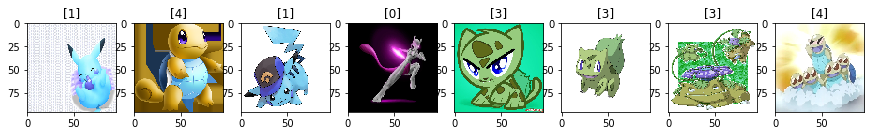

In [42]:
#plot some predictions:
def vis_pred(X):
    plt.figure(1,figsize=(15, 10))
    for i in range(1,9):
        c = random.randint(0, 100)
        img = X[c]
        plt.subplot(5,8,i)
        plt.imshow(img)
        plt.title([np.argmax(model.predict(img.reshape(1,96,96,3)))])
vis_pred(X_test)

In [43]:
# These are our predictions:
# 0: Bulbasaur
# 1: Charmander
# 2: Mewtwo
# 3: Pikachu
# 4: Squirtle

In [44]:
# Now we'll make predictions on our test dataset

In [47]:
path = 'Test'  # Specifies path of dataset. 
classes = os.listdir(path)  # Gives list of classes
print('Total number of categories are', len(classes))

# We'll see the number of images in each class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
print('Total number of images in dataset is', sum(list(counts.values())))

('Total number of categories are', 1)
('Total number of images in dataset is', 187)


In [62]:
# Now we'll take the required images from these 5 classes and make a list as shown in the code

X = []  # List for images
Y = []  # List for labels

# Loop through all classes
for c in classes:
    # Reading, resizing and adding image and label to lists
    for i in os.listdir(dir_path):
        image = cv2.imread(os.path.join(dir_path, i))
        try:
            resized = cv2.resize(image, (96, 96))  # Resize image to (96, 96)
            X.append(resized)
            Y.append(label)
        except:  # If we can't read a particular image we skip it
            print(os.path.join(dir_path, i), "[ERROR] can't read the file")
            continue

print("Done")

Done


In [63]:
# Convert list with images to numpy array and reshape it
X = np.array(X).reshape(-1, 96, 96, 3)

# Scaling the data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

In [64]:
len(X)

280

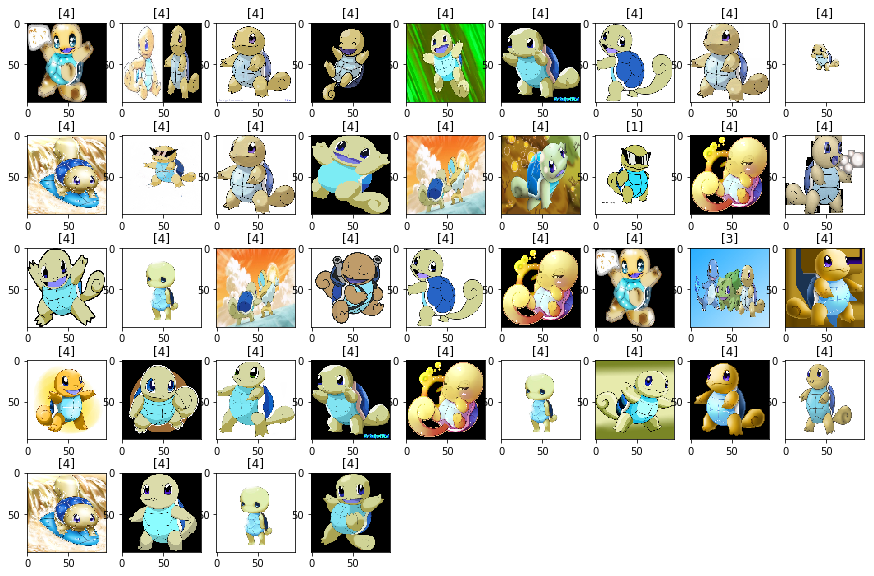

In [76]:
def vis_pred(X):
    plt.figure(1,figsize=(15, 10))
    for i in range(1, 41):
        c = random.randint(0, 100)
        img = X[c]
        plt.subplot(5,9,i)
        plt.imshow(img)
        plt.title([np.argmax(model.predict(img.reshape(1,96,96,3)))])
vis_pred(X)

In [77]:
# We'll now save our model

In [78]:
model.save_weights("model_pokemon_classifier.h5")

In [79]:
# Now we can predict some unseen data. We take some random pictures for each class from internet and try to predict
# them, so we take some urls from Google images and put them in lists as shown.

# In the below code we have taken some URLs for the respective images as shown

In [92]:
mewtwo = ['https://cdn.bulbagarden.net/upload/thumb/7/78/150Mewtwo.png/250px-150Mewtwo.png',
         'https://cdn.vox-cdn.com/thumbor/sZPPvUyKyF97UEU-nNtVnC3LpF8=/0x0:1750x941/1200x800/filters:focal(878x316:1158x596)/cdn.vox-cdn.com/uploads/chorus_image/image/63823444/original.0.jpg',
         'https://images-na.ssl-images-amazon.com/images/I/61j5ozFjJ0L._SL1024_.jpg']

pikachu = ['https://lh3.googleusercontent.com/proxy/DrjDlKlu9YonKbj3iNCJNJ3DGqzy9GjeXXSUv-TcVV4UN9PMCAM5yIkGLPG7wYo3UeA4sq5OmUWM8M6K5hy2KOAhf8SOL3zPH3axb2Xo3HX2XTU8M2xW4X6lVg=w720-h405-rw',
          'https://giantbomb1.cbsistatic.com/uploads/scale_medium/0/6087/2437349-pikachu.png',
          'https://johnlewis.scene7.com/is/image/JohnLewis/237525467']

charmander = ['https://img.pokemondb.net/artwork/large/charmander.jpg',
             'https://www.pokemoncenter.com/wcsstore/PokemonCatalogAssetStore/images/catalog/products/P5073/701-03990/P5073_701-03990_01.jpg',
             'https://static.posters.cz/image/750/%D0%A7%D0%B0%D1%88%D0%BA%D0%B0/pokemon-charmander-glow-i72513.jpg']

bulbasaur = ['https://img.pokemondb.net/artwork/large/bulbasaur.jpg',
            'https://ae01.alicdn.com/kf/HTB1aWullxSYBuNjSsphq6zGvVXaR/Big-Size-55-CM-Plush-Toy-Squirtle-Bulbasaur-Charmander-Toy-Sleeping-Pillow-Doll-For-Kid-Birthday.jpg',
            'https://cdn.bulbagarden.net/upload/thumb/f/f7/Bulbasaur_Detective_Pikachu.jpg/250px-Bulbasaur_Detective_Pikachu.jpg']

squirtle = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/007.png',
           'https://cdn.vox-cdn.com/thumbor/l4cKX7ZWargjs-zlxOSW2WZVgfI=/0x0:2040x1360/1200x800/filters:focal(857x517:1183x843)/cdn.vox-cdn.com/uploads/chorus_image/image/61498573/jbareham_180925_ply0802_0030.1537570476.jpg',
           'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fblogs-images.forbes.com%2Fdavidthier%2Ffiles%2F2018%2F07%2FSquirtle_Squad.jpg']

test_df = [mewtwo, pikachu, charmander, bulbasaur, squirtle]

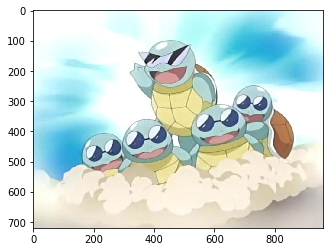

In [94]:
# Lists to store our future data. In this code we'll use the URLs and store images in val_x and labels in val_y
val_x = []
val_y = []

for i, urls in enumerate(test_df):
    for url in urls:        
        r = requests.get(url, stream = True).raw
        image = np.asarray(bytearray(r.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        val_x.append(image)
        val_y.append(i)

plt.imshow(image[:, :, ::-1])

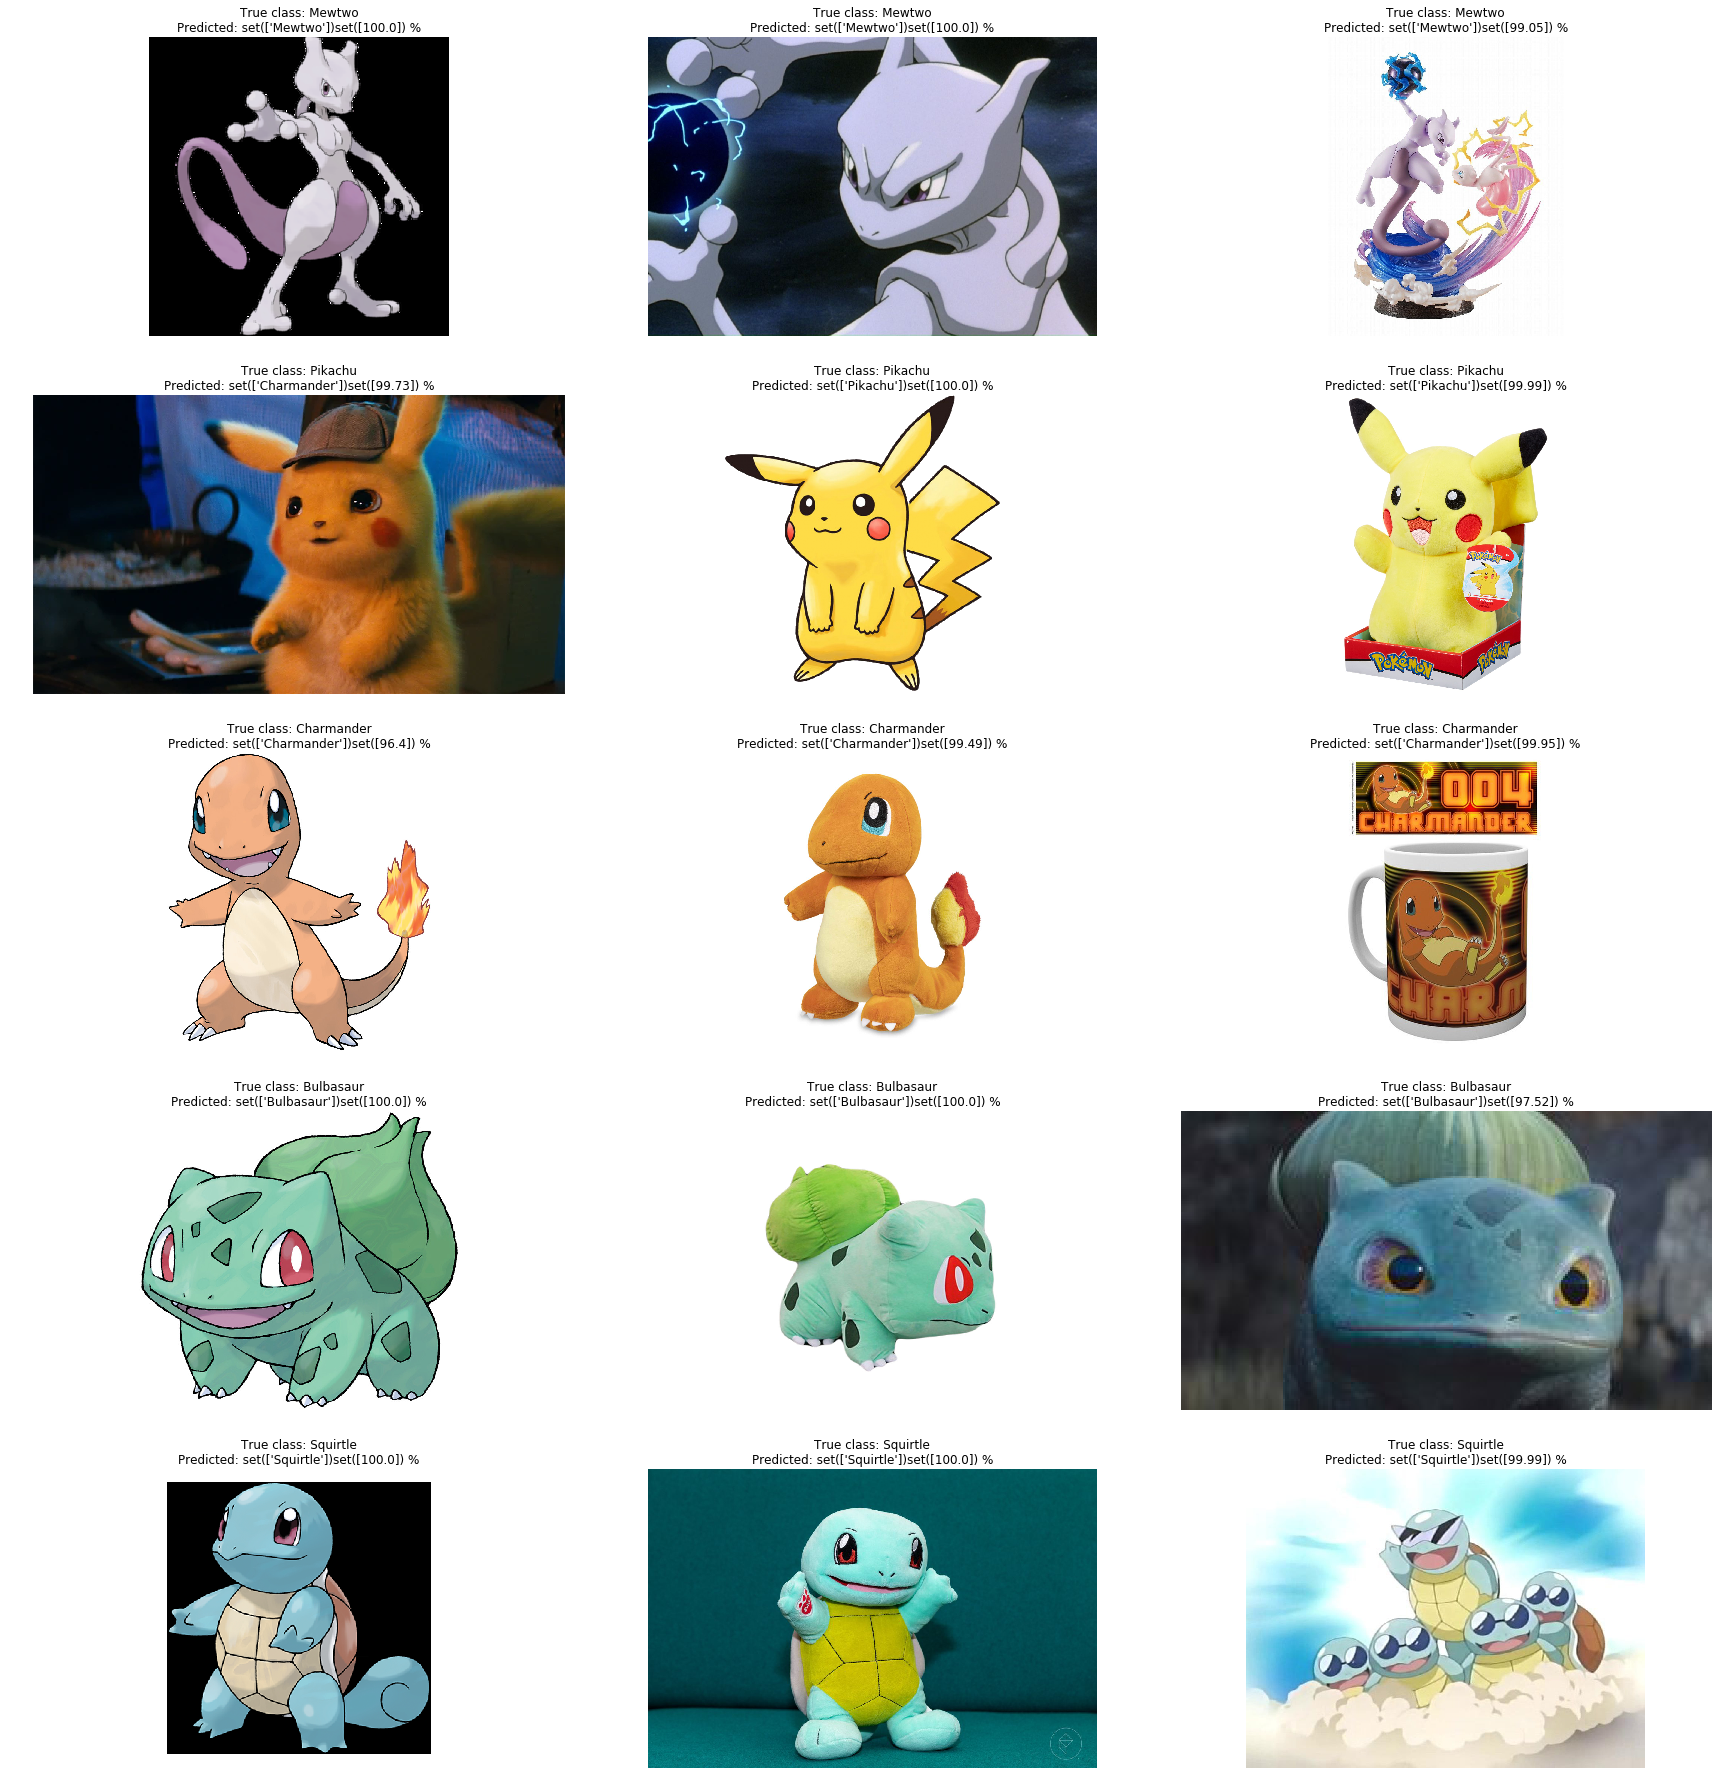

In [130]:
rows = 5
cols = 3

fig = plt.figure(figsize = (25, 25))

for i, j in enumerate(zip(val_x, val_y)):  # i - for subplots
    orig = j[0]  # Original, not resized image
    label = j[1]  # Label for that image
    
    image = cv2.resize(orig, (96, 96))  # Resizing image to (96, 96)
    image = image.reshape(-1, 96, 96, 3) / 255.0  # Reshape and scale resized image
    preds = model.predict(image)  # Predicting image
    pred_class = np.argmax(preds)  # Defining predicted class
    
    true_label = 'True class: {}'.format(imbalanced[label])
    pred_label = 'Predicted: {}{} %'.format({imbalanced[pred_class]}, {round(preds[0][pred_class] * 100, 2)})
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(orig[:, :, ::-1])
    plt.title('{}\n{}'.format(true_label, pred_label))
    plt.axis('off')
    
plt.tight_layout()

In [131]:
# model.load_weights('model_pokemon_classifier.h5')
# The above command is used to load our model